**Κατέβασμα του λεξικού από την spacy**

In [ ]:
#!python -m spacy download el_core_news_sm

**Σύνδεση του gdrive για να φέρουμε τα csvs των κειμένων και να αποθηκεύουμε csvs ή εικόνες που φτιάχνουμε** 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Εισαγωγή βιβλιοθηκών**

In [ ]:
import pandas as pd
%matplotlib inline
import numpy as np
import glob
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

# Διαβάζουμε το EmoLex

Το emolex (EMOtional LEXicon) είναι ένα λεξικό στο οποίο οι λέξεις που περιέχει έχουν αξιολογηθεί ως προς το συναισθηματικό φορτίο που μεταφέρουν.

Το λεξικό έχει δημιουργηθεί στην αγγλική γλώσσα και έχει μεταφραστεί σε 100 γλώσσες με google translate, μεταξύ των οποίων είναι και τα ελληνικά.

Μπορείτε να κατεβάσετε όλες τις γλώσσες από εδώ: http://www.saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [ ]:
filepath = "https://raw.githubusercontent.com/datajour-gr/DataJournalism/main/Bachelor%20Lessons%202023/Lesson%2010/NRC_GREEK_Translated_6_2020.csv"

In [ ]:
emolex_df = pd.read_csv(filepath)
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
emolex_df.tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13167,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13168,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13169,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13170,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**drop_duplicates() και dropna()**

Με την εντολή ```drop_duplicates()``` αφαιρούμε τις γραμμές που έχουν ίδιο περιεχόμενο (κρατάμε μόνο την πρώτη). Με την παράμετρο ```subset=['word']``` ορίζουμε ότι θα αφαιρεθούν οι γραμμές που έχουν ίδιο περιεχόμενο **μόνο** στη στήλη ```word```.

Με την εντολή ```dropna()``` αφαιρούμε τις γραμμές που δεν έχουν τιμή σε οποιαδήποτε στήλη.

Με την εντολή ```reset_index``` κάνουμε επαναρίθμηση του index μετά την αφαίρεση γραμμών του df, ώστε η αρίθμηση να είναι συνεχής. Με την παράμετρο ```drop=True``` στο ```reset_index()``` πετάμε το παλιό index. 

**Note**: Αν δεν βάλουμε την παράμετρο ```drop=True```, το παλιό index θα προστεθεί σαν στήλη στο df. Αυτό μπορεί να είναι χρήσιμο σε κάποιες περιπτώσεις, όπως θα δούμε και παρακάτω.

In [ ]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True, drop=True)

In [ ]:
emolex_df.tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13156,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13157,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13158,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13159,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13160,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Εισαγωγή της βιβλιοθήκης spacy για να έχουμε δυνατότητες nlp**

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('el_core_news_sm')

## Διαβάζουμε τα άρθρα



Τα δικά σας άρθρα (csv) θα είναι στο gdrive σας

In [ ]:
efsyn_full_articles_df = pd.read_csv("https://raw.githubusercontent.com/datajour-gr/DataJournalism/main/Bachelor%20Lessons%202023/Lesson%2010/efsyn_full_articles_ekloges_2023_7_5_2023.csv")

In [ ]:
len(efsyn_full_articles_df)

120

In [ ]:
efsyn_full_articles_df.head(1)

,site,url,section,title,date,author,full_text
0,efsyn.gr,https://www.efsyn.gr/politiki/392624_ena-debat...,ΠΟΛΙΤΙΚΗ,Ένα debate με πέντε πολιτικούς αρχηγούς,2023-06-06 14:40,efsyn.gr,Τη διεξαγωγή μια τηλεμαχίας μεταξύ των πολιτικ...


**Φτιάχνουμε ένα df στο οποίο κρατάμε μόνο το ```date``` και το ```full_text```**

Μετονομάζουμε τη στήλη ```full_text``` σε ```text```

In [ ]:
short_efsyn_fa_df = efsyn_full_articles_df[['date','full_text' ]]
short_efsyn_fa_df = short_efsyn_fa_df.rename(columns={'full_text': 'text'} )

In [ ]:
short_efsyn_fa_df.tail()

,date,text
115,2023-05-30 10:22,Δεν θα συμμετέχει στις εκλογές της 25ης Ιουνίο...
116,2023-05-30 10:01,«Η ΟΚΔΕ (Οργάνωση Κομμουνιστών Διεθνιστών Ελλά...
117,2023-05-30 09:28,Το χθεσινό ρεπορτάζ της «Εφ.Συν.» για τις σχέσ...
118,2023-05-30 07:39,Συνεδριάζει σήμερα το μεσημέρι στο υπουργείο Ε...
119,2023-05-30 06:00,Την παρθενική της συνεδρίαση πραγματοποίησε χθ...


**Μετατρέπουμε το ```date``` σε ```datetime```**

In [ ]:
short_efsyn_fa_df.dtypes

date    object
text    object
dtype: object

In [ ]:
short_efsyn_fa_df['date'] = pd.to_datetime(short_efsyn_fa_df['date'], format='%Y-%m-%d %H:%M')

In [ ]:
short_efsyn_fa_df.dtypes

date    datetime64[ns]
text            object
dtype: object

In [ ]:
# εαν θέλουμε να πετάξουμε urls που μπορεί να υπάρχουν στο κείμενο
#short_efsyn_fa_df['text'] = short_efsyn_fa_df['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ", regex=True)

In [ ]:
short_efsyn_fa_df.head()

,date,text
0,2023-06-06 14:40:00,Τη διεξαγωγή μια τηλεμαχίας μεταξύ των πολιτικ...
1,2023-06-06 14:18:00,Το δρόμο για τη διεξαγωγή της τηλεμαχία δείχνε...
2,2023-06-06 13:48:00,Με υποσχέσεις με φορολογικές μειώσεις πήγε και...
3,2023-06-06 13:31:00,Με τον αλαζονικό αέρα της πρωτιάς προσέρχεται ...
4,2023-06-06 12:51:00,Μπούμερανγκ γυρίζουν στη Ν.Δ. τα fake news με ...


**Φτιάχνουμε έναν vectorizer από τις λέξεις του συναισθηματικού λεξικού**

In [ ]:
emolex_df['word'].head(3)

0              αφεση
1    ενορκη βεβαιωση
2            εχοντας
Name: word, dtype: object

In [ ]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word,
                      lowercase=False, 
                      strip_accents = 'unicode',  
                      stop_words= list(nlp.Defaults.stop_words),
                      ngram_range=(1, 2))

**Μετράμε πόσες φορές εμφανίζονται οι λέξεις του συναισθηματικού λεξικού στα κείμενα των άρθρων**

Εφαρμόζουμε τον vectorizer στη στήλη ```text``` του df των άρθρων (matrix). 

Από τον vectorizer φτιάχνουμε ένα λεξικό (vocab).

Φτιάχνουμε ένα df με στήλες τις λέξεις του λεξικού, γραμμές τα άρθρα και τιμές τη συχνότητα εμφάνισης της κάθε λέξεις στο κάθε κείμενο.

In [ ]:
matrix = vec.fit_transform(short_efsyn_fa_df['text'])
vocab = vec.get_feature_names_out()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε',

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
wordcount_df.shape

(120, 13161)

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#CountVectorizer(stop_words='english', binary=True)
# Θέλω να ελέγξω μόνο τις λέξεις που υπάρχουν στο συναισθηματικό λεξικό

#CountVectorizer(analyzer = 'word', 
#                strip_accents = 'unicode', 
#                token_pattern='[Α-Ωα-ωΆ-Ώά-ώ]{2,}', 
#                stop_words= lc_stop_words_df['stop_w'].tolist())

**Φτιάχνουμε λίστες με τις λέξεις για θετικότητα/αρνητικότητα και για κάθε συναίσθημα**

In [ ]:
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
emolex_df[emolex_df.Anger == 1].tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13094,διεξοδος,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13096,ζωυφια,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
13100,θυματοποιω,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13128,αποτυχημενος,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13156,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Φτιάξε μια λίστα με positive words
positive_words = emolex_df[emolex_df.Positive == 1]['word']

# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']

# Φτιάξε μια λίστα με anger words
angry_words = emolex_df[emolex_df.Anger == 1]['word']

# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']

# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']

# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']

# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']

# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']

# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']

# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']

Οι λίστες που φτιάξαμε είναι της μορφής:

In [ ]:
trust_words

8                        αμην
15             γαμηλιο ταξιδι
24       διευθυντρια σχολειου
38                 επικοινωνω
45                   εκκλησια
                 ...         
13039                  αληθης
13075             αναμφιβολως
13079             ανυπερβατος
13113            αναθηματικος
13114       αποδειξη πληρωμης
Name: word, Length: 1259, dtype: object

Οι λέξεις/φράσεις της κάθε λίστας είναι ονόματα στηλών στο wordcount_df

In [ ]:
wordcount_df.tail(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Αν εφαρμόσουμε τη λίστα με τις λέξεις/φράσεις ενός συναισθήματος σαν επιλογέα στηλών στο wordcount_df, μπορούμε να "φιλτράρουμε" μόνο αυτές τις συγκεκριμένες στήλες

In [ ]:
wordcount_df[trust_words].tail(1)

,αμην,γαμηλιο ταξιδι,διευθυντρια σχολειου,επικοινωνω,εκκλησια,εν τω μεταξυ,ευαγγελιο,κυριε,λιστα ελεγχου,λυρικη σκηνη,...,ηλιακο ωρολογιο,συνεργιστικος,διπλο ποδηλατο,ισαξιος,ανακωχη,αληθης,αναμφιβολως,ανυπερβατος,αναθηματικος,αποδειξη πληρωμης
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Αν στο τέλος προσθέσουμε την εντολή `sum(axis=1)` θα πάρουμε το άθροισμα των εμφανίσεων όλων των λέξεων/φράσεων ενός συναισθήματος σε κάθε άρθρο

In [ ]:
wordcount_df[trust_words].sum(axis=1)

0       7
1       1
2      21
3       1
4       5
       ..
115     0
116    31
117     9
118     1
119    12
Length: 120, dtype: int64

**Στο df των άρθρων, δημιουργούμε νέες στήλες (μία για κάθε συναίσθημα) με τιμές το σύνολο των εμφανίσεων λέξεων/φράσεων κάθε συναισθήματος σε κάθε άρθρο**

Το df των άρθρων έχει την ημερομηνία και το κείμενο κάθε άρθρου.

In [ ]:
short_efsyn_fa_df.head(3)

,date,text
0,2023-06-06 14:40:00,Τη διεξαγωγή μια τηλεμαχίας μεταξύ των πολιτικ...
1,2023-06-06 14:18:00,Το δρόμο για τη διεξαγωγή της τηλεμαχία δείχνε...
2,2023-06-06 13:48:00,Με υποσχέσεις με φορολογικές μειώσεις πήγε και...


Δημιουργούμε στήλες συναισθημάτων

In [ ]:
short_efsyn_fa_df['anger'] = wordcount_df[angry_words].sum(axis=1)

short_efsyn_fa_df['positive'] = wordcount_df[positive_words].sum(axis=1)

short_efsyn_fa_df['joy'] = wordcount_df[joy_words].sum(axis=1)

short_efsyn_fa_df['disgust'] = wordcount_df[disgust_words].sum(axis=1)

short_efsyn_fa_df['surprise'] = wordcount_df[surprise_words].sum(axis=1)

short_efsyn_fa_df['trust'] = wordcount_df[trust_words].sum(axis=1)

short_efsyn_fa_df['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)

short_efsyn_fa_df['sadness'] = wordcount_df[sadness_words].sum(axis=1)

short_efsyn_fa_df['negative'] = wordcount_df[negative_words].sum(axis=1)

short_efsyn_fa_df['fear'] = wordcount_df[fear_words].sum(axis=1)

In [ ]:
short_efsyn_fa_df

,date,text,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2023-06-06 14:40:00,Τη διεξαγωγή μια τηλεμαχίας μεταξύ των πολιτικ...,2,7,1,0,0,7,2,4,10,5
1,2023-06-06 14:18:00,Το δρόμο για τη διεξαγωγή της τηλεμαχία δείχνε...,0,1,0,0,0,1,0,0,2,0
2,2023-06-06 13:48:00,Με υποσχέσεις με φορολογικές μειώσεις πήγε και...,9,22,6,11,5,21,7,5,19,10
3,2023-06-06 13:31:00,Με τον αλαζονικό αέρα της πρωτιάς προσέρχεται ...,1,2,0,4,0,1,1,4,5,1
4,2023-06-06 12:51:00,Μπούμερανγκ γυρίζουν στη Ν.Δ. τα fake news με ...,3,10,0,8,3,5,6,3,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-05-30 10:22:00,Δεν θα συμμετέχει στις εκλογές της 25ης Ιουνίο...,1,2,0,1,1,0,1,4,5,0
116,2023-05-30 10:01:00,«Η ΟΚΔΕ (Οργάνωση Κομμουνιστών Διεθνιστών Ελλά...,28,30,12,6,14,31,14,13,37,23
117,2023-05-30 09:28:00,Το χθεσινό ρεπορτάζ της «Εφ.Συν.» για τις σχέσ...,3,8,1,4,2,9,3,3,5,4
118,2023-05-30 07:39:00,Συνεδριάζει σήμερα το μεσημέρι στο υπουργείο Ε...,0,2,1,0,0,1,0,0,0,0


**Κάνουμε index τη στήλη `date`**

In [ ]:
short_efsyn_fa_df.reset_index(inplace=True)
short_efsyn_fa_df.set_index('date', inplace=True)
short_efsyn_fa_df

,index,text,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
date,,,,,,,,,,,,
2023-06-06 14:40:00,0,Τη διεξαγωγή μια τηλεμαχίας μεταξύ των πολιτικ...,2,7,1,0,0,7,2,4,10,5
2023-06-06 14:18:00,1,Το δρόμο για τη διεξαγωγή της τηλεμαχία δείχνε...,0,1,0,0,0,1,0,0,2,0
2023-06-06 13:48:00,2,Με υποσχέσεις με φορολογικές μειώσεις πήγε και...,9,22,6,11,5,21,7,5,19,10
2023-06-06 13:31:00,3,Με τον αλαζονικό αέρα της πρωτιάς προσέρχεται ...,1,2,0,4,0,1,1,4,5,1
2023-06-06 12:51:00,4,Μπούμερανγκ γυρίζουν στη Ν.Δ. τα fake news με ...,3,10,0,8,3,5,6,3,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-30 10:22:00,115,Δεν θα συμμετέχει στις εκλογές της 25ης Ιουνίο...,1,2,0,1,1,0,1,4,5,0
2023-05-30 10:01:00,116,«Η ΟΚΔΕ (Οργάνωση Κομμουνιστών Διεθνιστών Ελλά...,28,30,12,6,14,31,14,13,37,23
2023-05-30 09:28:00,117,Το χθεσινό ρεπορτάζ της «Εφ.Συν.» για τις σχέσ...,3,8,1,4,2,9,3,3,5,4


### Δουλεύοντας με χρονοσειρές (timeseries)

**Μετράμε τον μ.ο. του αριθμού των λέξεων ανά ημέρα** 

Με groupby

<Axes: xlabel='date'>

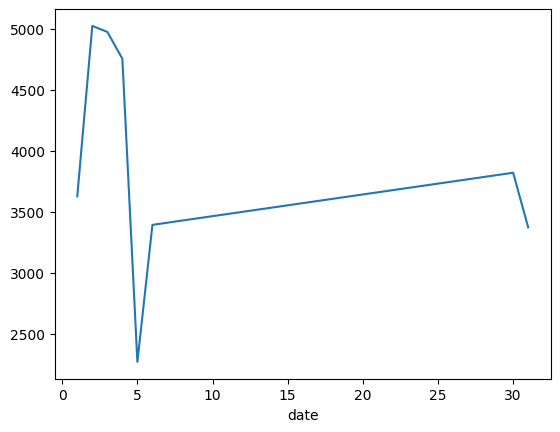

In [ ]:
short_efsyn_fa_df['text'].str.len().groupby(by=short_efsyn_fa_df.index.day).mean().plot() 

Με resample()

Με το resample μπορούμε να κάνουμε πολλά πράγματα: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html

<Axes: xlabel='date'>

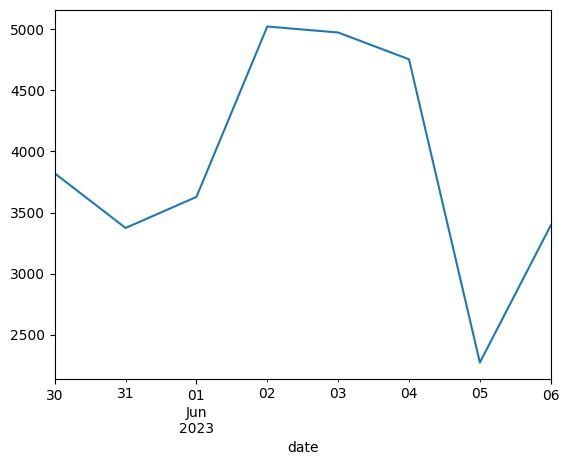

In [ ]:
short_efsyn_fa_df['text'].str.len().resample('D').mean().plot() 

**Μετράμε το πλήθος των άρθρων ανά ημέρα** 

<Axes: ylabel='date'>

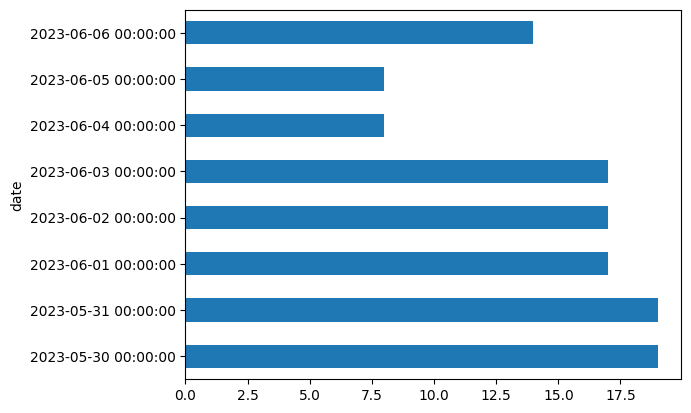

In [ ]:
short_efsyn_fa_df['text'].resample('D').count().plot(kind='barh') 

**Μετράμε τη θετικότητα/αρνητικότητα και το συναισθηματικό πρόσιμο των άρθρων ανά ημέρα**

<Axes: xlabel='date'>

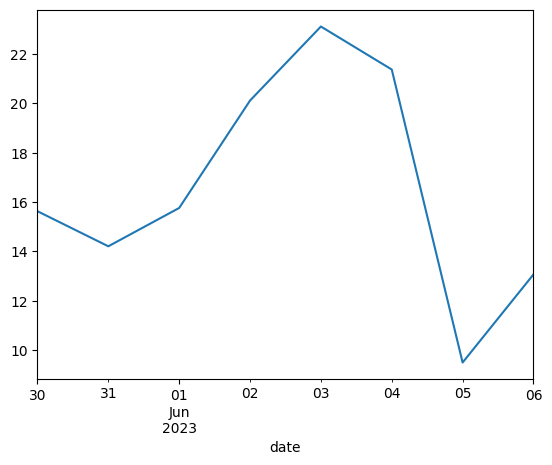

In [ ]:
short_efsyn_fa_df['positive'].resample('D').mean().plot() 

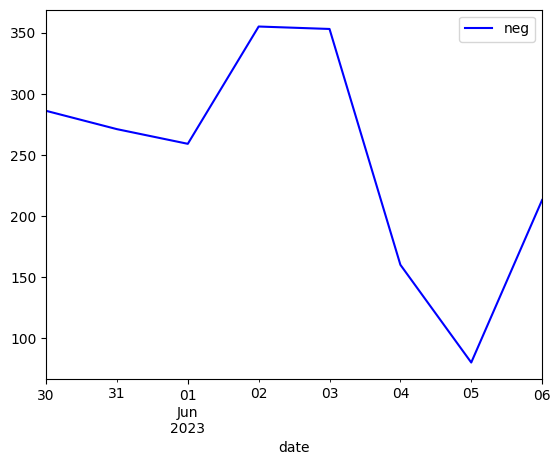

In [ ]:
short_efsyn_fa_df['negative'].resample('D').sum().plot(color = 'b',label = 'neg').legend() 

Αν έχουμε μεγάλη timeseries μπορούμε να μεγαλώσουμε το μήκος του γρφήματος

<Axes: xlabel='date'>

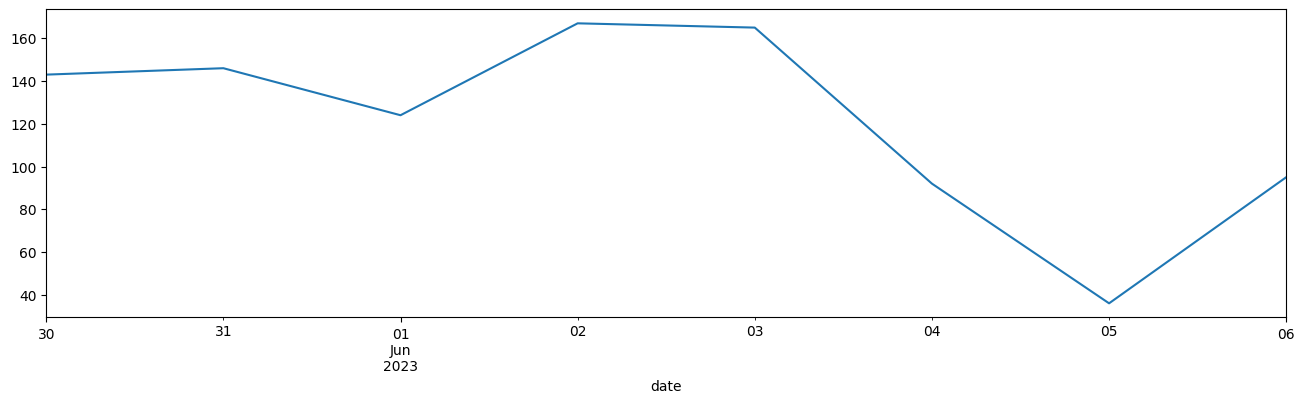

In [ ]:
short_efsyn_fa_df['anger'].resample('D').sum().plot(figsize=(16,4))

Μπορούμε να εμφανίσουμε πολλά linecharts στο ίδιο γράφημα

<Axes: xlabel='date'>

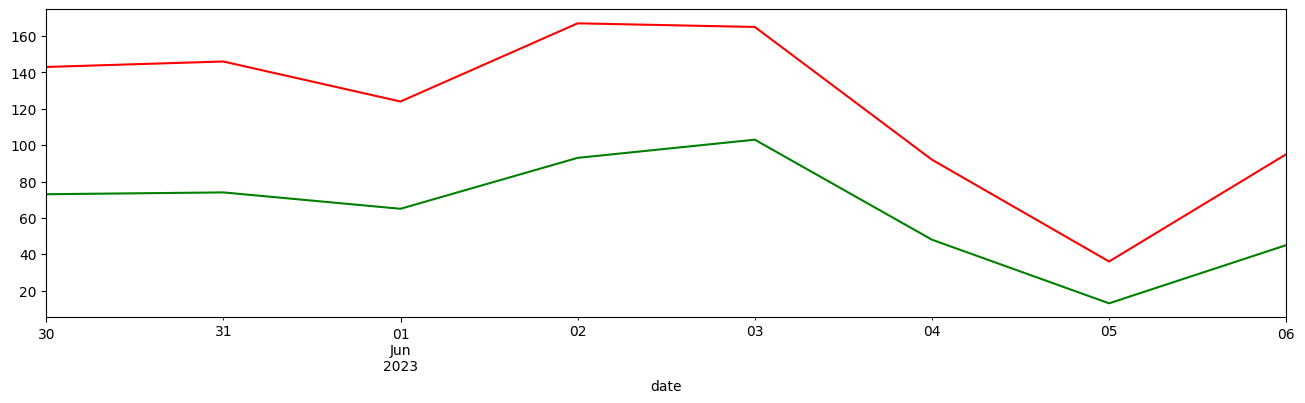

In [ ]:
ax = short_efsyn_fa_df['anger'].resample('D').sum().plot(figsize=(16,4), color = 'red')
short_efsyn_fa_df['joy'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'green')

<Axes: xlabel='date'>

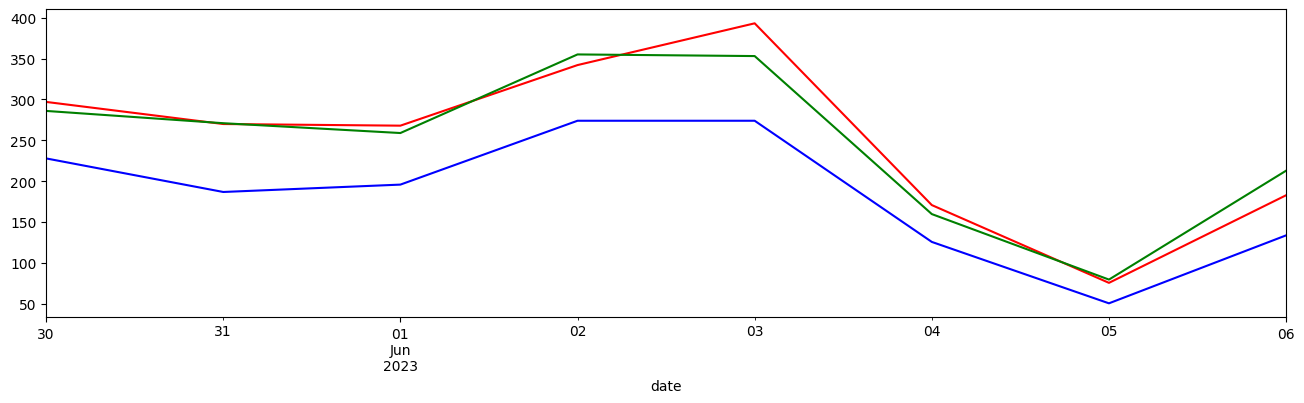

In [ ]:
ax = short_efsyn_fa_df['positive'].resample('D').sum().plot(figsize=(16,4), color = 'red')
short_efsyn_fa_df['negative'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'green')
short_efsyn_fa_df['trust'].resample('D').sum().plot(figsize=(16,4), ax = ax, color = 'blue')

Μπορούμε να χρησιμοποιήσουμε διαφορετικό style για τα γραφήματα.

https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')

In [ ]:
#plt.style.use('classic')
#plt.style.use('ggplot')
plt.style.use('Solarize_Light2')
#plt.style.use('seaborn-v0_8-bright')

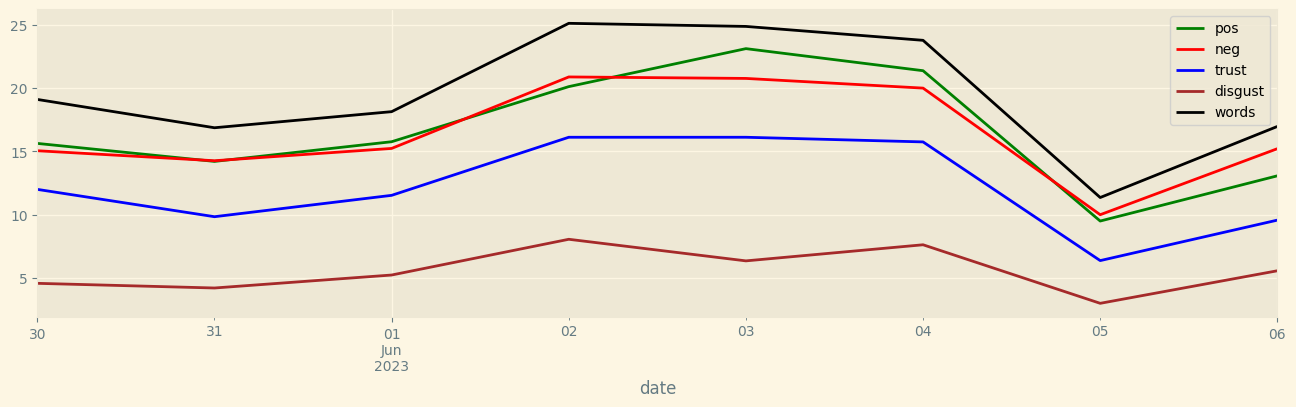

In [ ]:
ax = short_efsyn_fa_df['positive'].resample('D').mean().plot(figsize=(16,4), 
                                                          color = 'g', label='pos')
short_efsyn_fa_df['negative'].resample('D').mean().plot(figsize=(16,4), ax = ax, 
                                                   label = 'neg', color = 'r')
short_efsyn_fa_df['trust'].resample('D').mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'trust',color = 'blue').legend()
short_efsyn_fa_df['disgust'].resample('D').mean().plot(figsize=(16,4), ax = ax, 
                                                label = 'disgust',color = 'brown').legend()
(short_efsyn_fa_df['text'].str.len().resample('D').mean()/200).plot(figsize=(16,4), ax = ax, # διαιρώ το mean των λέξεων με το 200 για να πλησιάσει στην κλίμακα τα άλλα
                                                label = 'words',color = 'black').legend() 

**ΠΑΡΑΤΗΡΗΣΕΙΣ** (και λίγη θεωρία)

Θα προσέξατε ότι παρά τις μικροδιαφοροποιήσεις τους, οι γραμμές της θετικότητας/αρνητικότητας και των συναισθημάτων ανεβοκατεβαίνουν όλες μαζί στις διάφορες μέρες. Αυτό συμβαίνει γιατί αυτό που μετριέται είναι η συχνότητα (αριθμός εμφανίσεων) των αντίστοιχων λέξεων/φράσεων. Οι γραμμές αυτές ακολουθούν στο ανεβοκατέβασμα τον αριθμό λέξεων των άρθρων ανά ημέρα.

Ακριβώς επειδή ένα άρθρο περισσότερων λέξεων θα έχει περισσότερες π.χ. θετικές αλλά και αρνητικές λέξεις, θά έχει περισσότερη **και θετικότητα και αρνητικότητα** από ένα άρθρο με λιγότερες λέξεις.

Επομένως, η σύγκριση των κειμένων π.χ. ως προς το polarity δεν μπορεί να γίνει με απλή σύγκριση των συχνοτήτων των λέξεων/φράσεων από άρθρο σε άρθρο.

Ένας τρόπος αξιόπιστης σύγκρισης είναι η σύγκριση των διαφορών π.χ. θετικότητας/αρνητικότητας.

Δηλαδή, μπορούμε να δούμε στο παραπάνω γράφημα ότι σε όλες τις μέρες η γραμή της θετικότητας είναι κάτω από τη γραμμή της αρνητικότητας, εκτός από τις 2/6 και 5/6. Επίσης η μεγαλύτερη διαφορά θετικότητας/αρνητικότητας είναι στις 3/6 (περισσότερο θετικά άρθρα).

<Axes: xlabel='date'>

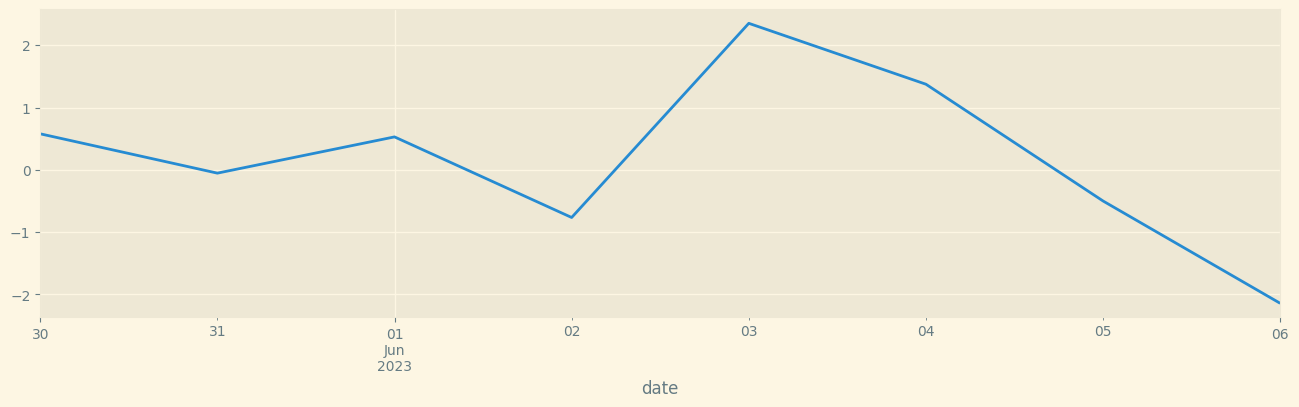

In [ ]:
short_efsyn_fa_df['pos/neg'] = short_efsyn_fa_df['positive'] - short_efsyn_fa_df['negative']
short_efsyn_fa_df['pos/neg'].resample('D').mean().plot(figsize=(16,4))

Το παραπάνω γράφημα μας δίνει μια καλύτερη εικόνα της διακύμανσης θετικότητας/αρνητικότητας στα άρθρα ανά ημέρα. Οι θετικές τιμές σημαίνουν ότι υπερτερεί η θετικότητα, ενώ οι αρνητικές ότι υπερτερεί η αρνητικότητα.

Με αυτο τον τρόπο έχουμε βρει ποιο είναι το polarity στα άρθρα ανά ημέρα, όμως ακόμα, η σύγκριση ανάμεσα στις μέρες, δηλαδή το να δούμε ποια μέρα έχουμε το μαγαλύτερο polarity είναι στρεβλή, γιατί η σύγκριση γίνεται με απόλυτους αριθμούς λέξεων/φράσεων. 

Μπορούμε να ξεφύγουμε και από τη στρέβλωση των απόλυτων αριθμών που εξαρτώνται από το μέγεθος των κειμένων και να πάμε σε διαφορά των ποσοστών.

In [ ]:
#plt.style.use('grayscale')
plt.style.use('seaborn-v0_8-darkgrid')

<Axes: xlabel='date'>

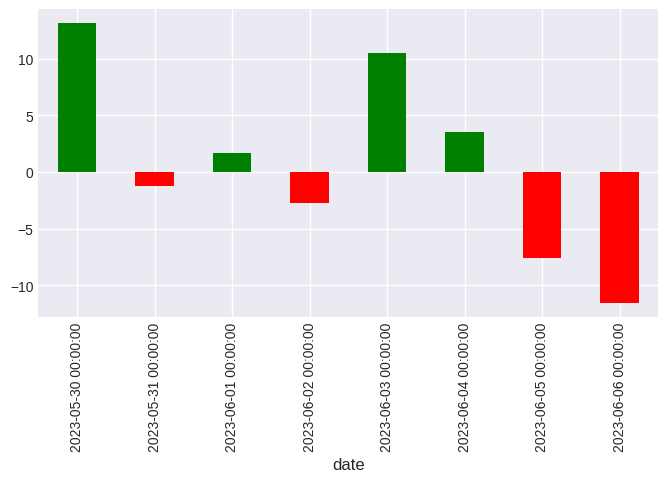

In [ ]:
short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'] = short_efsyn_fa_df.positive*100//short_efsyn_fa_df[['positive','negative']].sum(
        axis=1) - short_efsyn_fa_df.negative*100//short_efsyn_fa_df[['positive','negative']].sum(axis=1)

short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'].resample('D').mean().plot(kind='bar',
                                                                               color=(short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'].resample('D').mean()>0
                                                                               ).map({True: 'g', False: 'r'}), figsize=(8,4))

Βλέπουμε λοιπόν ότι το πιο έντονο polarity δεν το έχουμε στις 3/6 όπως νομίζαμε ότι φαινόταν στο πρώτο linechart, αλλά στις 30/5 (θετικότητα) και στις 6/6 (αρνητικότητα).

### Ας εντοπίσουμε το άρθρο με τη μεγαλύτερη θετικότητα και το άρθρο με τη μεγαλύτερη αρνητικότητα

In [ ]:
short_efsyn_fa_df[(short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'] == short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'].max()) |
                  (short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'] == short_efsyn_fa_df['(-)αρνητικότητα | θετικότητα(+)'].min())
                  ][['index', 'positive', 'negative', '(-)αρνητικότητα | θετικότητα(+)']] 

,index,positive,negative,(-)αρνητικότητα | θετικότητα(+)
date,,,,
2023-06-05 11:04:00,20,0,1,-100.0
2023-05-30 19:17:00,104,1,0,100.0
2023-05-30 07:39:00,118,2,0,100.0


Υπάρχουν 2 άρθρα φουλ θετικά στις 30/5, αλλά το πιο αρνητικό δεν είναι στις 6/6 (όπου ο μ.ο. όλων των άρθρων είναι αρνητικός), αλλά στις 5/6.

Ποια είναι αυτά τα άρθρα;

In [ ]:
efsyn_full_articles_df.loc[[20,104,118], ['url','title', 'full_text']]

,url,title,full_text
20,https://www.efsyn.gr/politiki/392490_arnitikos...,Αρνητικός στο τεστ κορονοϊού ο Κυριάκος Μητσοτ...,Σύντομο το πέρασμα της νόσο στον πρόεδρο της Ν...
104,https://www.efsyn.gr/ellada/koinonia/391878_an...,Ανανεωμένοι κατάλογοι ετεροδημοτών για τις βου...,Αυξημένοι κατά 31.250 πολίτες θα είναι οι εκλο...
118,https://www.efsyn.gr/politiki/391753_synedriaz...,Συνεδριάζει η Διακομματική Επιτροπή για τις εν...,Συνεδριάζει σήμερα το μεσημέρι στο υπουργείο Ε...


Βλέπουμε ότι παρά την πολύ μικρή συχνότητα θετικών ή αρνητικών λέξεων, η εκτίμηση του polarity είναι αρκετά επιτυχής.

### Συναισθηματικά δίπολα

Όπως με το polarity που προκύπτει από το ζεύγος positivity/negativity, έτσι και τα 8 βασικά συναισθήματα κατηγοριοποιούνται σε 4 συναισθηματικά δίπολα:
- χαρά/λύπη,
- εμπιστοσύνη/αποστροφή,
- φόβος/θυμός,
- έκπληξη/προσμονή

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Plutchik-wheel.svg/800px-Plutchik-wheel.svg.png)

Εικόνα: Ο τροχός του Plutchik 

Για την κατηγοριοποίηση των συναισθημάτων: 
[Emotional classification](https://en.wikipedia.org/wiki/Emotion_classification)

Επομένως, με την τεχνική που εφαρμόσαμε στο polarity μπορούμε να υπολογίσουμε και το πρόσιμο του κάθε συναισθηματικού δίπολου και να εντοπίσουμε τα κείμενα με τη μεγαλύτερη συναισθηματική φόρτιση.